In [ ]:
computational model

operations


black box: neural network 

# Deep Learning with TensorFlow

Classical machine learning relies on using statistics to determine relationships between features and labels, and can be very effective for creating predictive models. However, a massive growth in the availability of data coupled with advances in the computing technology required to process it has led to the emergence of new machine learning techniques that mimic the way the brain processes information in a structure called an artificial neural network.

TensorFlow is a framework for creating machine learning models, including deep neural networks (DNNs). In this example, we'll use Tensorflow to create a simple neural network that classifies penguins into species based on the length and depth of their culmen (bill), their flipper length, and their body mass.

> **Citation**: The penguins dataset used in the this exercise is a subset of data collected and made available by [Dr. Kristen
Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a
member of the [Long Term Ecological Research
Network](https://lternet.edu/).

## Explore the dataset

Before we start using TensorFlow to create a model, let's load the data we need from the Palmer Islands penguins dataset, which contains observations of three different species of penguin.

> **Note**: In reality, you can solve the penguin classification problem easily using classical machine learning techniques without the need for a deep learning model; but it's a useful, easy to understand dataset with which to demonstrate the principles of neural networks in this notebook.

In [1]:
import pandas as pd

# load the training dataset (excluding rows with null values)
penguins = pd.read_csv('data/penguins.csv').dropna()

# Deep Learning models work best when features are on similar scales
# In a real solution, we'd implement some custom normalization for each feature, but to keep things simple
# we'll just rescale the FlipperLength and BodyMass so they're on a similar scale to the bill measurements
penguins['FlipperLength'] = penguins['FlipperLength']/10
penguins['BodyMass'] = penguins['BodyMass']/100

# The dataset is too small to be useful for deep learning
# So we'll oversample it to increase its size
for i in range(1,3):
    penguins = penguins.append(penguins)

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample

C:\Users\monika201103\AppData\Local\Temp\1\ipykernel_26516\1646010116.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  penguins = penguins.append(penguins)
C:\Users\monika201103\AppData\Local\Temp\1\ipykernel_26516\1646010116.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  penguins = penguins.append(penguins)


,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
143,40.7,17.0,19.0,37.25,0
150,36.0,17.1,18.7,37.00,0
153,50.0,16.3,23.0,57.00,1
197,43.6,13.9,21.7,49.00,1
127,41.5,18.3,19.5,43.00,0
292,50.3,20.0,19.7,33.00,2
218,46.2,14.4,21.4,46.50,1
167,49.3,15.7,21.7,58.50,1
133,37.5,18.5,19.9,44.75,0
114,39.6,20.7,19.1,39.00,0


In [2]:
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,18.1,37.5,0
1,39.5,17.4,18.6,38.0,0
2,40.3,18.0,19.5,32.5,0
4,36.7,19.3,19.3,34.5,0
5,39.3,20.6,19.0,36.5,0


In [4]:
penguins.tail(10)

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
334,50.2,18.8,20.2,38.00,2
335,45.6,19.4,19.4,35.25,2
336,51.9,19.5,20.6,39.50,2
337,46.8,16.5,18.9,36.50,2
338,45.7,17.0,19.5,36.50,2
339,55.8,19.8,20.7,40.00,2
340,43.5,18.1,20.2,34.00,2
341,49.6,18.2,19.3,37.75,2
342,50.8,19.0,21.0,41.00,2
343,50.2,18.7,19.8,37.75,2


The **Species** column is the label our model will predict. Each label value represents a class of penguin species, encoded as 0, 1, or 2. The following code shows the actual species to which these class labels corrrespond.

In [5]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[',row[0], row[1], row[2],row[3], int(row[4]), ']',penguin_classes[int(row[-1])])

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 49.3 19.9 20.3 40.5 2 ] Chinstrap
[ 38.2 20.0 19.0 39.0 0 ] Adelie
[ 50.0 19.5 19.6 39.0 2 ] Chinstrap
[ 38.1 16.5 19.8 38.25 0 ] Adelie
[ 49.9 16.1 21.3 54.0 1 ] Gentoo
[ 46.2 14.1 21.7 43.75 1 ] Gentoo
[ 50.7 15.0 22.3 55.5 1 ] Gentoo
[ 42.1 19.1 19.5 40.0 0 ] Adelie
[ 43.8 13.9 20.8 43.0 1 ] Gentoo
[ 42.7 13.7 20.8 39.5 1 ] Gentoo


As is common in a supervised learning problem, we'll split the dataset into a set of records with which to train the model, and a smaller set with which to validate the trained model.

In [6]:
from sklearn.model_selection import train_test_split

features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
label = 'Species'
   
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(penguins[features].values,
                                                    penguins[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of features and labels:")

# Take a look at the first 25 training features and corresponding labels
for n in range(0,24):
    print(x_train[n], y_train[n], '(' + penguin_classes[y_train[n]] + ')')

Training Set: 957, Test Set: 411 

Sample of features and labels:
[51.1 16.5 22.5 52.5] 1 (Gentoo)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.5 16.2 22.9 58. ] 1 (Gentoo)
[39.3 20.6 19.  36.5] 0 (Adelie)
[42.5 20.7 19.7 45. ] 0 (Adelie)
[50.  15.3 22.  55.5] 1 (Gentoo)
[50.2  18.7  19.8  37.75] 2 (Chinstrap)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.1  14.5  21.2  46.25] 1 (Gentoo)
[43.2 16.6 18.7 29. ] 2 (Chinstrap)
[38.8  17.6  19.1  32.75] 0 (Adelie)
[37.8 17.1 18.6 33. ] 0 (Adelie)
[45.8 14.2 21.9 47. ] 1 (Gentoo)
[43.8 13.9 20.8 43. ] 1 (Gentoo)
[36.  17.1 18.7 37. ] 0 (Adelie)
[43.3 13.4 20.9 44. ] 1 (Gentoo)
[36.  18.5 18.6 31. ] 0 (Adelie)
[41.1  19.   18.2  34.25] 0 (Adelie)
[33.1 16.1 17.8 29. ] 0 (Adelie)
[40.9 13.7 21.4 46.5] 1 (Gentoo)
[45.2 17.8 19.8 39.5] 2 (Chinstrap)
[48.4 14.6 21.3 58.5] 1 (Gentoo)
[43.6 13.9 21.7 49. ] 1 (Gentoo)
[38.5  17.9  19.   33.25] 0 (Adelie)


The *features* are the measurements for each penguin observation, and the *label* is a numeric value that indicates the species of penguin that the observation represents (Adelie, Gentoo, or Chinstrap).

## Install and import TensorFlow libraries

Since we plan to use TensorFlow to create our penguin classifier, we'll need to run the following two cells to install and import the libraries we intend to use.

> **Note** *Keras* is an abstraction layer over the base TensorFlow API. In most common machine learning scenarios, you can use Keras to simplify your code.

In [7]:
import tensorflow

In [8]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras import optimizers

# Set random seed for reproducability
tensorflow.random.set_seed(0)

print("Libraries imported.")
#print('Keras version:',keras.__version__)
print('TensorFlow version:',tensorflow.__version__)

Libraries imported.
TensorFlow version: 2.16.1


In [9]:
# Set data types for float features
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Set data types for categorical labels
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
print('Ready...')

Ready...


## Define a neural network

Now we're ready to define our neural network. In this case, we'll create a network that consists of 3 fully-connected layers:
* An input layer that receives an input value for each feature (in this case, the four penguin measurements) and applies a *ReLU* activation function.
* A hidden layer that receives ten inputs and applies a *ReLU* activation function.
* An output layer that uses a *SoftMax* activation function to generate an output for each penguin species (which represent the classification probabilities for each of the three possible penguin species). Softmax functions produce a vector with probability values that sum to 1.

In [10]:
# Define a classifier network
hl = 10 # Number of hidden layer nodes

model = Sequential()
model.add(Dense(hl, input_dim=len(features), activation='relu'))
model.add(Dense(hl, input_dim=hl, activation='relu'))
model.add(Dense(len(penguin_classes), input_dim=hl, activation='softmax'))

print(model.summary())

C:\Users\monika201103\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Train the model

To train the model, we need to repeatedly feed the training values forward through the network, use a loss function to calculate the loss, use an optimizer to backpropagate the weight and bias value adjustments, and validate the model using the test data we withheld.

To do this, we'll apply an Adam optimizer to a categorical cross-entropy loss function iteratively over 50 epochs.

In [11]:
#hyper-parameters for optimizer
learning_rate = 0.00001
# opt = optimizers.Adam(lr=learning_rate)
opt = optimizers.Adam(learning_rate=0.00001)


model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the model over 50 epochs using 10-observation batches and using the test holdout dataset for validation
num_epochs = 50
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=10, validation_data=(x_test, y_test))

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4454 - loss: 6.3001 - val_accuracy: 0.4234 - val_loss: 6.1902
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4454 - loss: 6.0465 - val_accuracy: 0.4234 - val_loss: 5.9361
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4454 - loss: 5.7956 - val_accuracy: 0.4234 - val_loss: 5.6846
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4454 - loss: 5.5473 - val_accuracy: 0.4234 - val_loss: 5.4360
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4454 - loss: 5.3020 - val_accuracy: 0.4234 - val_loss: 5.1904
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4454 - loss: 5.0596 - val_accuracy: 0.4234 - val_loss: 4.9476
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4454 - loss: 4.8199 - val_accuracy: 0.4234 - val_loss: 4.7078
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4454 - loss: 4.5832 - val_accuracy: 0.4234 - val_loss:

While the training process is running, let's try to understand what's happening:

1. In each *epoch*, the full set of training data is passed forward through the network. There are four features for each observation, and four corresponding nodes in the input layer - so the features for each observation are passed as a vector of four values to that layer. However, for efficiency, the feature vectors are grouped into batches; so actually a matrix of multiple feature vectors is fed in each time.
2. The matrix of feature values is processed by a function that performs a weighted sum using initialized weights and bias values. The result of this function is then processed by the activation function for the input layer to constrain the values passed to the nodes in the next layer.
3. The weighted sum and activation functions are repeated in each layer. Note that the functions operate on vectors and matrices rather than individual scalar values. In other words, the forward pass is essentially a series of nested linear algebra functions. This is the reason data scientists prefer to use computers with graphical processing units (GPUs), since these are optimized for matrix and vector calculations.
4. In the final layer of the network, the output vectors contain a probability value for each possible class (in this case, classes 0, 1, and 2). This vector is processed by a *loss function* to determine how far the values calculated by the network are from the actual values - so for example, suppose the output for a Gentoo penguin (class 1) observation is \[0.3, 0.4, 0.3\]. The correct prediction should be \[0.0, 1.0, 0.0\], so the variance between the predicted and actual values (how far away the each predicted value is from what it should be) is \[0.3, 0.6, 0.3\]. This variance is aggregated for each batch and maintained as a running aggregate to calculate the overall level of error (*loss*) incurred by the training data for the epoch. The accuracy (proportion of correct predictions based on the highest probability value in the output vector) for the training data is also calculated.
5. At the end of each epoch, the validation data is passed through the network, and its loss and accuracy are also calculated. It's important to do this because it enables us to compare the performance of the model using data on which it was not trained, helping us determine if it will generalize well for new data or if it's *overfitted* to the training data.
6. After all the data has been passed forward through the network, the output of the loss function for the *training* data (but <u>not</u> the *validation* data) is passed to the opimizer. The precise details of how the optimizer processes the loss vary depending on the specific optimization algorithm being used; but fundamentally you can think of the entire network, from the input layer to the loss function as being one big nested (*composite*) function. The optimizer applies some differential calculus to calculate *partial derivatives* for the function with respect to each weight and bias value that was used in the network. It's possible to do this efficiently for a nested function due to something called the *chain rule*, which enables you to determine the derivative of a composite function from the derivatives of its inner function and outer functions. You don't really need to worry about the details of the math here (the optimizer does it for you), but the end result is that the partial derivatives tell us about the slope (or *gradient*) of the loss function with respect to each weight and bias value - in other words, we can determine whether to increase or decrease the weight and bias values in order to decrease the loss.
7. Having determined in which direction to adjust the weights and biases, the optimizer uses the *learning rate* to determine by how much to adjust them; and then works backwards through the network in a process called *backpropagation* to assign new values to the weights and biases in each layer.
8. Now the next epoch repeats the whole training, validation, and backpropagation process starting with the revised weights and biases from the previous epoch - which hopefully will result in a lower level of loss.
9. The process continues like this for 50 epochs.

## Review training and validation loss

After training is complete, we can examine the loss metrics we recorded while training and validating the model. We're really looking for two things:
* The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
* The training loss and validation loss should follow a similar trend, showing that the model is not overfitting to the training data.

Let's plot the loss metrics and see:

conda update matplotlib

conda install -f matplotlib

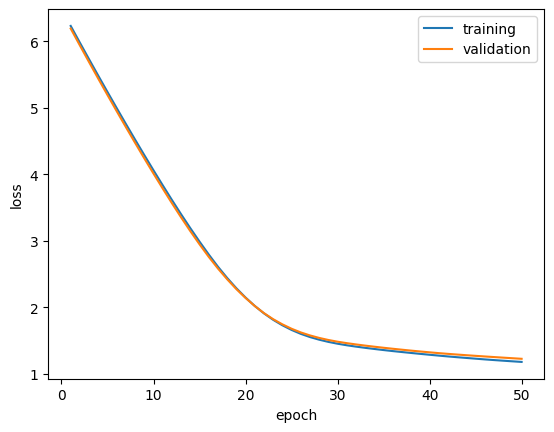

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## View the learned weights and biases

The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:
* Layer 1: There are four input values going to ten output nodes, so there should be 4 x 10 weights and 10 bias values.
* Layer 2: There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
* Layer 3: There are ten input values going to three output nodes, so there should be 10 x 3 weights and 3 bias values.

In [14]:
for layer in model.layers:
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    print('------------\nWeights:\n',weights,'\nBiases:\n', biases)

------------
Weights:
 [[-0.45662972  0.2956723   0.58989006  0.14230523  0.13319986 -0.6194532
  -0.5592989   0.2615792   0.14834113 -0.2667581 ]
 [ 0.57600796 -0.19049394 -0.42007428  0.10353564 -0.18913211 -0.05200529
   0.03295022  0.00155369  0.2082686   0.25982386]
 [ 0.6431078  -0.30211797  0.56212485 -0.35174045  0.16965574 -0.19070518
  -0.55206186  0.2602819   0.54809386 -0.16273957]
 [ 0.11142178  0.1410779  -0.6089776   0.17302766  0.3836473   0.07424039
   0.06953436  0.27524918 -0.21962643 -0.07606012]] 
Biases:
 [ 0.02529003 -0.02921524 -0.02642791  0.01655223 -0.02633579  0.
  0.          0.02792472 -0.01559251  0.        ]
------------
Weights:
 [[-0.36017025  0.1962772  -0.50431484  0.4546039   0.5234962   0.3805795
  -0.29355913  0.08579212  0.4475183  -0.20332655]
 [-0.4513168   0.3624056   0.12779409 -0.40815657  0.01697176 -0.2615579
   0.04152862  0.22546639 -0.09038949  0.21289669]
 [ 0.09142024 -0.4845207  -0.05178529  0.5255114  -0.09093516  0.26293662
   0.07

## Evaluate model performance

So, is the model any good? The raw accuracy reported from the validation data would seem to indicate that it predicts pretty well; but it's typically useful to dig a little deeper and compare the predictions for each possible class. A common way to visualize the performance of a classification model is to create a *confusion matrix* that shows a crosstab of correct and incorrect predictions for each class.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


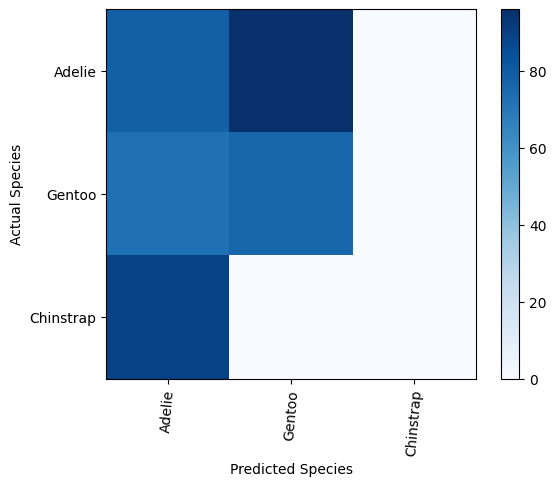

In [15]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=85)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

The confusion matrix should show a strong diagonal line indicating that there are more correct than incorrect predictions for each class.

## Save the trained model
Now that we have a model we believe is reasonably accurate, we can save its trained weights for use later.

In [16]:
# Save the trained model
modelFileName = 'models/penguin-classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

model saved as models/penguin-classifier.h5


## Use the trained model

When we have a new penguin observation, we can use the model to predict the species.

In [17]:
# Load the saved model
model = models.load_model(modelFileName)

# CReate a new array of features
x_new = np.array([[50.4,15.3,20,50]])
print ('New sample: {}'.format(x_new))

# Use the model to predict the class
class_probabilities = model.predict(x_new)
predictions = np.argmax(class_probabilities, axis=1)

print(penguin_classes[predictions[0]])

New sample: [[50.4 15.3 20.  50. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Adelie


## Learn more

This notebook was designed to help you understand the basic concepts and principles involved in deep neural networks, using a simple Tensorflow example. To learn more about Tensorflow, take a look at the <a href="https://www.tensorflow.org/" target="_blank">Tensorflow web site</a>.